In [17]:
# Cell 1: Imports & Utilities
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [18]:
# Cell 2: Focal Loss & Model
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return loss.mean()

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class AdvancedMultimodalModel(nn.Module):
    def __init__(self, seq_len=2000, flux_dim=1, tabular_dim=5):
        super().__init__()
        self.input_proj = nn.Linear(flux_dim, 128)
        self.pos_encoder = PositionalEncoding(128, seq_len)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True),
            num_layers=4
        )
        self.tabular_mlp = nn.Sequential(
            nn.Linear(tabular_dim, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.GELU()
        )
        self.cross_attention = nn.MultiheadAttention(embed_dim=128, num_heads=4, batch_first=True)
        self.gate = nn.Sequential(nn.Linear(128, 128), nn.Sigmoid())
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, flux_x, tabular_x):
        x = self.input_proj(flux_x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        t = self.tabular_mlp(tabular_x).unsqueeze(1)
        attn_output, _ = self.cross_attention(t, x, x)
        fused = self.gate(attn_output) * attn_output + (1 - self.gate(attn_output)) * t
        return self.classifier(fused.squeeze(1))


Using device: cpu

=== Training Run 1/3 ===
Epoch 1 - Loss: 0.0450 - F1: 0.4516
✅ Model saved.
Epoch 2 - Loss: 0.0432 - F1: 0.5000
✅ Model saved.
Epoch 3 - Loss: 0.0418 - F1: 0.5344
✅ Model saved.
Epoch 4 - Loss: 0.0399 - F1: 0.5333
Epoch 5 - Loss: 0.0371 - F1: 0.4885
Epoch 6 - Loss: 0.0345 - F1: 0.4567
Epoch 7 - Loss: 0.0326 - F1: 0.4426
Epoch 8 - Loss: 0.0308 - F1: 0.3611
Epoch 9 - Loss: 0.0286 - F1: 0.4538
Epoch 10 - Loss: 0.0286 - F1: 0.5102
Epoch 11 - Loss: 0.0228 - F1: 0.4673
Epoch 12 - Loss: 0.0209 - F1: 0.4524
Epoch 13 - Loss: 0.0213 - F1: 0.4600
Epoch 14 - Loss: 0.0164 - F1: 0.4186
Epoch 15 - Loss: 0.0161 - F1: 0.4103
Epoch 16 - Loss: 0.0159 - F1: 0.4651
Epoch 17 - Loss: 0.0140 - F1: 0.4124
Epoch 18 - Loss: 0.0113 - F1: 0.4054
Epoch 19 - Loss: 0.0126 - F1: 0.4267
Epoch 20 - Loss: 0.0086 - F1: 0.4471
Epoch 21 - Loss: 0.0081 - F1: 0.4571
Epoch 22 - Loss: 0.0068 - F1: 0.4750
Epoch 23 - Loss: 0.0060 - F1: 0.4722
⛔ Early stopping.
Run 1 - Best F1: 0.5344 at Threshold: 0.50

=== Tra

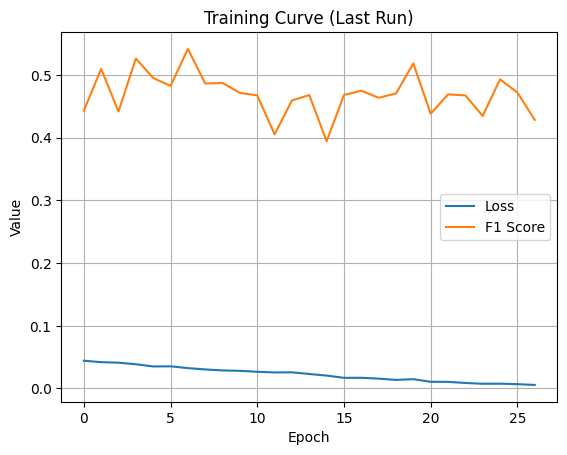

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import gc

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and filter
X_flux = np.load("X_flux_512.npy")[..., np.newaxis]  # Shape: (829, 512, 1)
X_tabular = np.load("X_tabular.npy")
y = np.load("y.npy")
mask = y != -1
X_flux, X_tabular, y = X_flux[mask], X_tabular[mask], y[mask]

# Train/Val split
Xf_train, Xf_val, Xt_train, Xt_val, y_train, y_val = train_test_split(
    X_flux, X_tabular, y, test_size=0.2, stratify=y, random_state=42
)

# Compute class weights for sampling
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weights = 1. / class_sample_count
samples_weight = np.array([weights[int(t)] for t in y_train])
samples_weight = torch.from_numpy(samples_weight).float()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# Tensor conversion
# Transpose Xf_train and Xf_val to [batch_size, channels, sequence_length]
Xf_train = Xf_train.transpose(0, 2, 1)  # From (663, 512, 1) to (663, 1, 512)
Xf_val = Xf_val.transpose(0, 2, 1)      # From (166, 512, 1) to (166, 1, 512)

train_dataset = TensorDataset(
    torch.tensor(Xf_train, dtype=torch.float32),
    torch.tensor(Xt_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
)
train_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler, pin_memory=True)

val_flux = torch.tensor(Xf_val, dtype=torch.float32)
val_tab = torch.tensor(Xt_val, dtype=torch.float32)
val_y = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

# AdvancedMultimodalModel
class AdvancedMultimodalModel(nn.Module):
    def __init__(self, flux_dim=512, tabular_dim=5):
        super().__init__()
        # Flux branch (CNN)
        self.flux_branch = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear(128 * (flux_dim // 4), 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Tabular branch
        self.tabular_branch = nn.Sequential(
            nn.Linear(tabular_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        # Fusion and classifier
        self.classifier = nn.Sequential(
            nn.Linear(64 + 64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, flux_x, tabular_x):
        flux_feat = self.flux_branch(flux_x)
        tab_feat = self.tabular_branch(tabular_x)
        combined = torch.cat((flux_feat, tab_feat), dim=1)
        return self.classifier(combined)

# Function to find optimal threshold
def find_optimal_threshold(val_y, val_probs):
    thresholds = np.linspace(0.1, 0.9, 81)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        preds = (val_probs > thresh).astype(int)
        f1 = f1_score(val_y, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
    return best_threshold, best_f1

# Training and ensembling
num_runs = 3
ensemble_probs = []
ensemble_val_f1 = []
best_thresholds = []

for run in range(num_runs):
    print(f"\n=== Training Run {run+1}/{num_runs} ===")
    torch.manual_seed(42 + run)  # Different seed for each run

    # Model + Optimizer + Loss
    model = AdvancedMultimodalModel().to(device)
    criterion = FocalLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Training
    train_loss_curve, val_f1_curve = [], []
    best_f1, patience, counter = 0, 20, 0
    min_delta = 0.008

    for epoch in range(30):
        model.train()
        total_loss = 0
        for xb, xt, yb in train_loader:
            xb, xt, yb = xb.to(device), xt.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb, xt)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            del xb, xt, yb, out
            gc.collect()

        train_loss_curve.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_flux.to(device), val_tab.to(device))
            val_probs = torch.sigmoid(val_out).detach().cpu().numpy()
            val_preds = (val_probs > 0.5).astype(int)
            f1 = f1_score(val_y, val_preds)
            val_f1_curve.append(f1)

        print(f"Epoch {epoch+1} - Loss: {train_loss_curve[-1]:.4f} - F1: {f1:.4f}")
        if f1 > best_f1 + min_delta:
            best_f1 = f1
            torch.save(model.state_dict(), f"best_model_run{run}.pt")
            counter = 0
            print("Model saved.")
        else:
            counter += 1
            if counter >= patience:
                print(" Early stopping.")
                break

    # Load best model for this run and get validation probabilities
    model.load_state_dict(torch.load(f"best_model_run{run}.pt"))
    model.eval()
    with torch.no_grad():
        val_out = model(val_flux.to(device), val_tab.to(device))
        val_probs_run = torch.sigmoid(val_out).detach().cpu().numpy()
        ensemble_probs.append(val_probs_run)

    # Find optimal threshold for this run
    thresh, f1 = find_optimal_threshold(val_y, val_probs_run)
    best_thresholds.append(thresh)
    ensemble_val_f1.append(f1)
    print(f"Run {run+1} - Best F1: {f1:.4f} at Threshold: {thresh:.2f}")

# Average predictions across runs
avg_probs = np.mean(ensemble_probs, axis=0)
avg_threshold = np.mean(best_thresholds)
final_preds = (avg_probs > avg_threshold).astype(int)

# Final evaluation with ensemble
print("\n📊 Ensemble Validation Results:")
print(f"Average Threshold: {avg_threshold:.2f}")
print(f"Ensemble F1 Scores: {ensemble_val_f1}")
print(f"Average F1 Score: {np.mean(ensemble_val_f1):.4f}")
print("\n🧾 Classification Report:")
print(classification_report(val_y, final_preds, target_names=["False Positive", "Confirmed"]))
print("\n🧮 Confusion Matrix:")
print(confusion_matrix(val_y, final_preds))

# Plotting
plt.plot(train_loss_curve, label="Loss")
plt.plot(val_f1_curve, label="F1 Score")
plt.title("Training Curve (Last Run)")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()